# Bayesian Learning

This lab introduces you to a Bayesian/probabilistic perspective of Machine Learning. In order to have full information about the underlying distributions, we will be using *synthetic datasets*, i.e. datasets that we sample from distributions that we define explicitly ourselves.

These data sets will be used to perform a Bayesian linear regression. We are looking at the MAP estimate and the posterior distribution of the model parameters. In order to keep it simple, we restrict ourselves to one-dimensional input spaces.

In [24]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Synthetic dataset for linear regression

We model the conditional distribution $p(y \mid x)$ given the marginal distribution $p(x)$ on $\mathbb{R}$ and a function $f: \mathbb{R} \rightarrow \mathbb{R}$  as follows:

$$ p(y \mid x) = f(x) + \epsilon \qquad \left(\epsilon \sim \mathcal{N}(0, \sigma^2)\right), $$

where $\epsilon \sim \mathcal{N}(0, \sigma^2)$ means that $\epsilon$ is a random variable normally distributed with zero mean and a variance of $\sigma^2$. Note that $f$ actually only has to be defined for $x$ with nonzero probability (this set of $x$ is called the *support of $p$*). Thus, we have fully specified the joint distribution $p(x, y) = p(x) p(y \mid x)$.

The function $f$ controls the relationship between $x$ and $y$. For example, if we use a linear function for $f$, there will be a linear relationship between $x$ and $y$ (plus some noise); hence, in this case, a linear regression model will be adequate to predict $y$ from $x$. 

To generate a data set $D = \{(x_i, y_i) \in X \times Y \mid 1 \leq i \leq N\}$ we sample tuples $(x, y)$ by first picking an $x$ from the distribution $p(x)$. To compute the $y$, we sample a noise-term $\epsilon$ from the normal distribution with the specified mean and variance, and compute $y = f(x) + \epsilon$. The output $(x, y)$ is then one sample of our data set. Since we sample independently and identically distributed (*i.i.d*) we do this process $N$ times to obtain $D$.

As ground work we first learn about the <a href="http://docs.scipy.org/doc/scipy/reference/stats.html">scipy.stats</a> package, which contains distributions to sample from or computing quantities such as the *probability density function* (*pdf*), and about Python generators.

First import the uniform and normal distributions.

In [25]:
from scipy.stats import uniform
from scipy.stats import norm

In [26]:
# Models uniform distribution on the interval [loc, loc+scale]
b = uniform(loc=0, scale=4)

In [29]:
print ("10 samples: {}".format(b.rvs(10)))
print ("Probablity density at x = 0: {}".format(b.pdf(0)))

10 samples: [1.810012   3.15872719 3.44412512 0.20275738 0.64700443 3.26143472
 2.81189193 0.29164517 1.75505302 0.40070477]
Probablity density at x = 0: 0.25


In the following code snippet we are sampling from a standard normal distribution and look at the distribution of the samples.

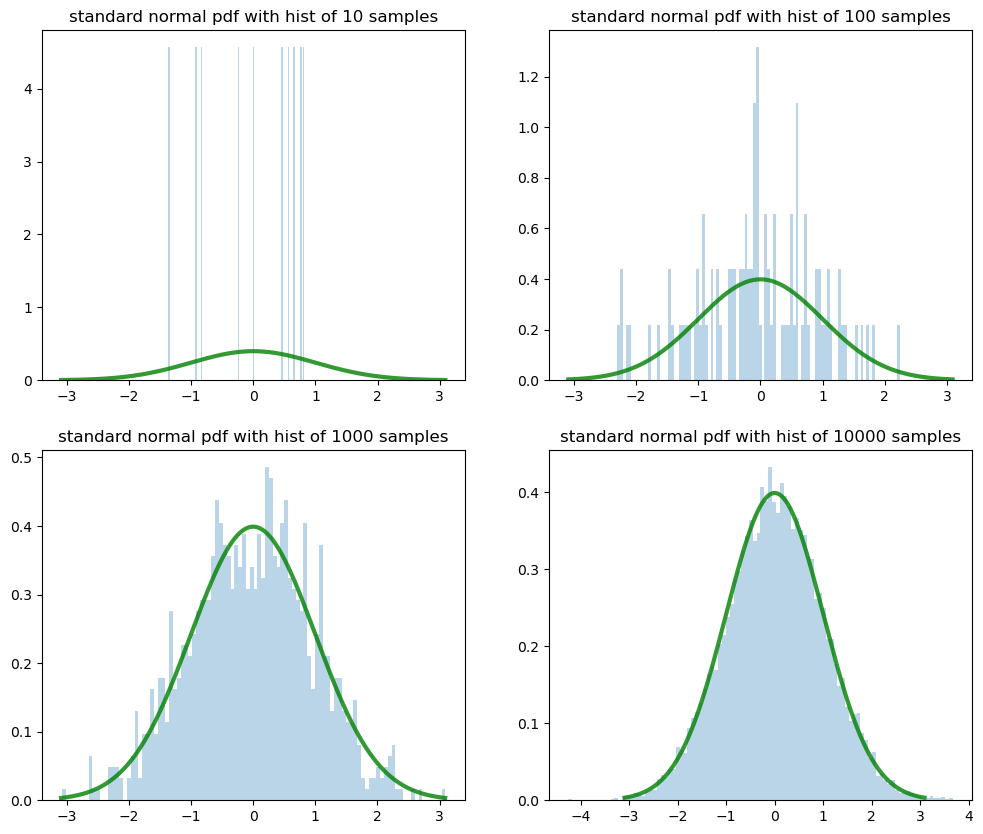

In [30]:
a = norm(loc=0, scale=1)

# this creates a grid of 2x2 plots
# axes is then a 2x2 np.ndarray
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# sample 1000 points from the 0.01 percentile to 0.99 percentile
x = np.linspace(norm.ppf(0.001), norm.ppf(0.999), 1000) 

num_samples = [10, 100, 1000, 10000]
# we go through the axes one by one, need to make the 2x2 matrix linear before
for i, ax in enumerate(axes.reshape(4)):
    normal_dist = norm(loc=0, scale=1)
    ax.plot(x, normal_dist.pdf(x), 'g', lw=3, alpha=.8)
    
    ys = normal_dist.rvs(size=num_samples[i])
    ax.hist(ys, density=True, bins=100, histtype="stepfilled", alpha=0.3)
    ax.set_title('standard normal pdf with hist of {} samples'.format(num_samples[i]))

Generators are a special kind of functions in Python. Instead of returning only a single value, they behave like an iterator, i.e.,  return a (possibly infinite) sequence of values. Syntactically, the only difference between a 'normal' function and a generator is that  a generator uses the <b>yield</b> keyword rather than <b>return</b>. Once <b>yield</b> is used in the definition of a function,  the <b>next()</b> method is generated automatically. Each time, the generator's <b>next()</b> method is called, the generator function is executed until the <b>yield</b> keyword is reached. Similar to <b>return</b>, it returns the value given as parameter. If the generator is told to generate more values (using <b>next()</b>), the execution continues from the point of the last call of <b>yield</b>. Typically, <b>yield</b> is inside a (usually infinite) loop.  As an example, we write a generator that generates the natural numbers $\mathbb{N}_0$, i.e. $0, 1, 2, \dots$.

In [31]:
def natural_numbers():
    i = 0
    
    while True: # infinite loop!
        yield i
        i += 1

In [32]:
gen = natural_numbers()
print (type(gen))
print (next(gen))
print ([next(gen) for i in range(100)]) # take 100 numbers, note that 0 was already generated!

<class 'generator'>
0
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]


<b>Exercise 1</b>: Complete the code of the following three generators:

- uniform_gen(a,b): generates a randomly sampled element from a uniform distribution with boundaries a and b. Assert that a < b.

- normal_gen(mean, std): generates a randomly sampled element from a normal distribution with mean=mean and variance=std². Assert that std >= 0.

- data_gen(f, x_gen, noise_gen): Generates data points (x, y), where x is assumed to be sampled using a generator function x_gen and y is f(x) + eps, where eps is assumed to be sampled using a generator function noise_gen (see introduction above). 

    You don't need to implement the two generator functions for x and eps here. 

In [33]:
def uniform_generator(a, b):
    assert a < b
    dist = uniform(loc=a, scale= b-a)
    
    while True: # infinite loop!
        yield dist.rvs(size=1)[0]
        
        
def normal_generator(mean, std):
    assert std>= 0
    dist = norm(loc=mean, scale= std)
    
    while True: # infinite loop!
        yield dist.rvs(size=1)[0]
    
        
def data_generator(f, x_gen, noise_gen):
    while True: # infinite loop!
        x = next(x_gen)
        yield x,f(x)+next(noise_gen)


In [34]:
import itertools
from scipy.stats import normaltest
    
try: 
    num_gen = uniform_generator(1, 5)
    numbers = [next(num_gen) for _ in range(1000)]
    
    assert all(1 <= num and num <= 5 for num in numbers), "The uniform generator"
    
    normal_gen = normal_generator(0, 1)
    numbers_normal = [next(normal_gen) for _ in range(1000)]
    
    k2, p = normaltest(numbers_normal)
    
    assert p > 1e-3, "The normal generator"
   
    def constant_generator(c):
        while True:
            yield c

    data_gen = data_generator(lambda x: x**2, uniform_generator(-1, 1), constant_generator(0))
    
    assert all([x**2 == y for x, y in itertools.islice(data_gen, 0, 1000)]), "The data generator"
    
    print ("The code seems fine.")
    
except AssertionError as err:
    print ("Currently there is a fault in: " + str(err))

The code seems fine.


## 2. Posterior Distribution of $\theta$ and MAP

We now perform a Bayesian linear regression on data that is generated as explained in the introduction above. x is sampled from a uniform distribution with lower bound 0 and upper bound 5. The label y of an instance x is generated via $f(x) = 5x + 3$ plus some normally distributed  noise eps that has a standard deviation of $2.5$.

In [35]:
sigma   = 2.5 # sigma of the noise, do not change this!

data_gen = data_generator(lambda x: 5*x + 3, uniform_generator(0, 5), normal_generator(0, sigma))
data = list(itertools.islice(data_gen, 0, 100)) # list of pairs (x, y)
x, y = zip(*data) # The asterisk unpacks data; i.e., this line corresponds to x,y=zip((x[0], y[0]), ((x[1], y[1])), ...)                         

Text(0.5, 1.0, 'Sampled data set')

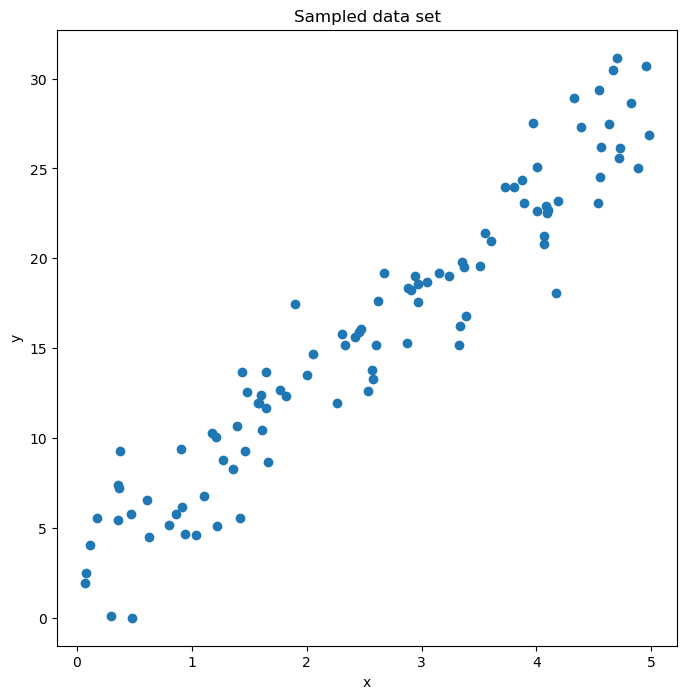

In [36]:
plt.figure(figsize=(8, 8))
plt.scatter(x, y)
plt.xlabel('x')
plt.ylabel('y')
plt.title("Sampled data set")

We also add a bias. More precisely we extend the vector $x$ to a matrix by writing it as a column and adding a vector of $1$ next to it.

In [37]:
N = len(x)
X = np.column_stack((np.asarray(x), np.ones(N)))

<b>Exercise 2</b>: Let $X$ be a data matrix with dimensions $N \times D$,  $y$ a label vector of dimension $D$. Moreover, let $\sigma$ be a noise parameter  (standard deviation of the output noise) and $\sigma_p$ the standard deviation for the prior distribution of the weights $\theta$. Implement the missing parts of the following functions:

- get_MAP: Returns the MAP estimate $\theta_{\text{MAP}}$ given $X, y, \sigma, \sigma_p$.

$$ \theta_{\text{MAP}} = \left(X^T X + \frac{\sigma^2}{\sigma_p^2} I\right)^{-1} X^T y. $$

- get_posterior_distribution_parameters: Returns the mean vector (equal to the MAP estimate) and the covariance matrix $\Sigma$ for the posterior distribution of $\theta$ given $X$ and $y$.

$$ \Sigma = \frac{1}{\sigma^2} X^T X + \frac{1}{\sigma_p^2} I. $$

In [38]:
def get_MAP(X, y, sigma, sigma_p):
    theta_MAP = 1/((X.T@X+(sigma**2)/(sigma_p**2))@np.identity(X.shape[1]))@X.T@y
    return np.reshape(theta_MAP, 2)

def get_posterior_distribution_parameters(X, y, sigma, sigma_p):
    Sigma = ((1/sigma**2)*X.T@X+(1/sigma_p**2))@(np.identity(X.shape[1]))
    return get_MAP(X, y, sigma, sigma_p), Sigma

In [39]:
sigma_p = 5

theta_MAP = get_MAP(X, y, sigma=sigma, sigma_p=sigma_p)
print("theta (MAP estimate): {}".format(theta_MAP))

theta (MAP estimate): [12.0903939  35.76825885]


To use multivariate normal distributions, a different distribution has to be imported from scipy.stats. We visualize the posterior distribution of the weights.

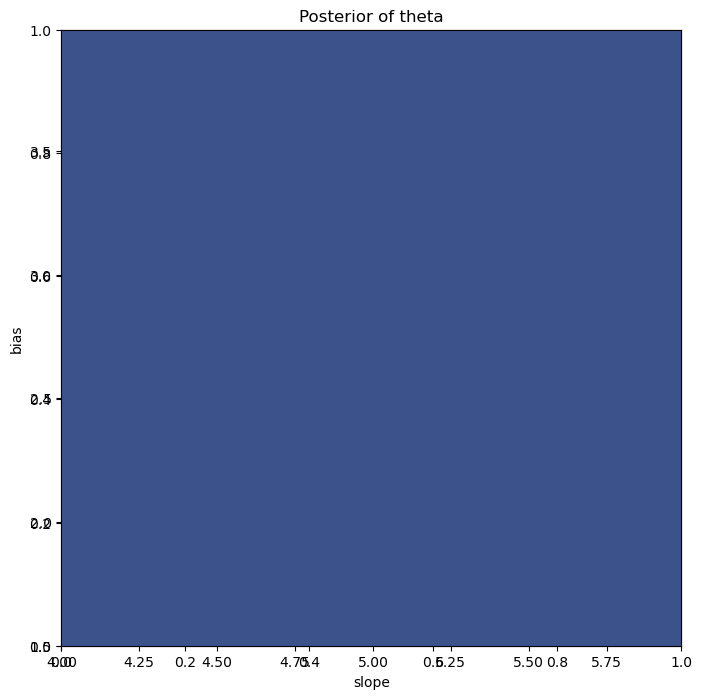

In [40]:
import warnings
from matplotlib.cbook import mplDeprecation
from scipy.stats import multivariate_normal

theta_MAP, Sigma = get_posterior_distribution_parameters(X, y, sigma, sigma_p)

mvn = multivariate_normal(theta_MAP,np.linalg.inv(Sigma))
thetas = mvn.rvs(5)

def generate_contour(mvn, ax):
    a, b = np.mgrid[4:6:.01, 1.5:4:.01]
    pos = np.dstack((a, b))
    ax = fig.add_subplot(111)
    ax.contourf(a, b, mvn.pdf(pos))
    
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.set_title("Posterior of theta")
ax.set_xlabel("slope")
ax.set_ylabel("bias")
generate_contour(mvn, ax)

We visualize the MAP estimate and sample posterior curves.

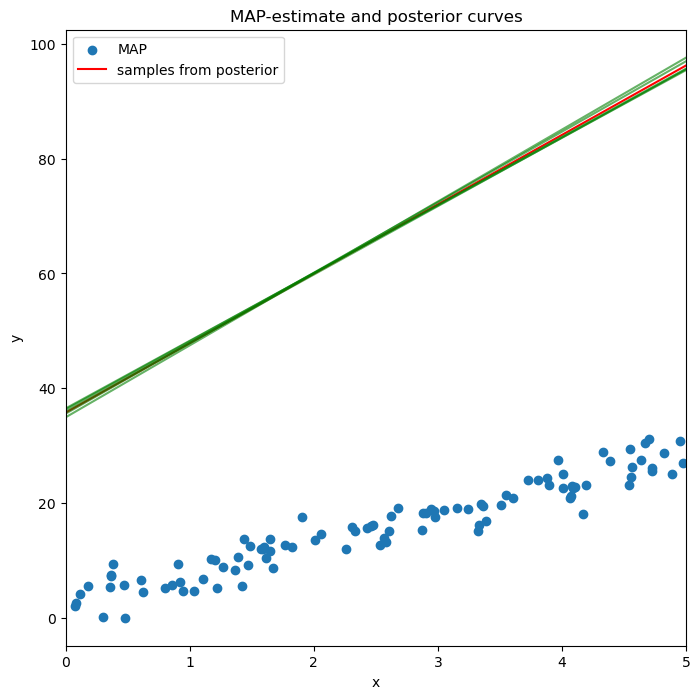

In [41]:
fig = plt.figure(figsize=(8, 8))
plt.scatter(x, y)
plt.xlabel('x')
plt.ylabel('y')
plt.title("MAP-estimate and posterior curves")

ps = np.linspace(0, 5, 1000)

def predict(theta):
    return lambda x: theta[0] * x + theta[1]

plt.plot(ps, list(map(predict(theta_MAP), ps)), "r-", label="MAP")

for theta in thetas:
    plt.plot(ps, list(map(predict(theta), ps)), "g-", alpha=0.6)
plt.legend(["MAP", "samples from posterior"], loc="best")
plt.xlim([0, 5])
plt.show()